## Gerekli Kütüphaneler

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import (
    roc_curve,
    auc,
    balanced_accuracy_score,
    roc_auc_score,
    classification_report,
)

import joblib
import warnings


## Dataset'in Okunması

In [2]:
df = pd.read_csv(
    "../../Dataset/Final_Dataset.csv",
    low_memory=False
)

In [3]:
print("✅ Loaded:", df.shape)
print("Columns:", list(df.columns), '\n')
df.head()

✅ Loaded: (390043, 15)
Columns: ['video_id', 'title', 'publishedAt', 'channelId', 'channelTitle', 'categoryId', 'trending_date', 'tags', 'view_count', 'likes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'description', 'is_trending'] 



,video_id,title,publishedAt,channelId,channelTitle,categoryId,trending_date,tags,view_count,likes,comment_count,thumbnail_link,comments_disabled,description,is_trending
0,G4M_621v1As,college farewell video#trending #viralshorts,2025-04-12T02:06:42Z,UC7k_7IF3s3TY-cowwxs_yWw,Vk_07_rider,22.0,2025-11-08,"college farewell video, DDU farewell video, fa...",125784084.0,1557178.0,1583.0,https://i.ytimg.com/vi/G4M_621v1As/default.jpg,0,DDU farewell party video \n college farewell v...,1
1,z2voqo_Jhx4,Busking in Manchester 🇬🇧 #blindfaith #guitar #...,2025-04-06T11:35:53Z,UCM_9JHB3xXPSzJfTkD86AtA,Leonardo Patrick,10.0,2025-11-08,NaN,94744011.0,925529.0,5849.0,https://i.ytimg.com/vi/z2voqo_Jhx4/default.jpg,0,NaN,1
2,jHIt9oHFLsw,This is what happens when you play Star Wars i...,2025-04-06T10:07:12Z,UC4YyKY5o60Kckk-GXOnhT2g,Violin Phonix,22.0,2025-11-08,NaN,61945818.0,1067412.0,4124.0,https://i.ytimg.com/vi/jHIt9oHFLsw/default.jpg,0,Full video : https://www.youtube.com/watch?v=Q...,1
3,gwRqLbWqKlM,LISA - FUTW (YouTube Music Nights Special Stag...,2025-03-19T03:29:33Z,UC6-BgjsBa5R3PZQ_kZ8hKPg,LLOUD Official,10.0,2025-11-08,"Blackpink, Lisa, Music, Fashion, K-Pop, kpop, ...",14555963.0,455816.0,20396.0,https://i.ytimg.com/vi/gwRqLbWqKlM/default.jpg,0,"LISA’s debut album, ‘Alter Ego’ is out now. Li...",1
4,prpRoyrutcE,Uljhi hai yeh kis jaal me tu…. Bengaluru ❤️,2025-04-14T10:17:58Z,UCiFXnvi8ESDukE25ol2foWQ,Mr.KiranJ,10.0,2025-11-08,NaN,26204942.0,336267.0,2333.0,https://i.ytimg.com/vi/prpRoyrutcE/default.jpg,0,NaN,1


## Özellik Çıkarımı

In [4]:
df["publishedAt"] = pd.to_datetime(df["publishedAt"], errors="coerce")

df["like_view_ratio"] = df["likes"] / (df["view_count"] + 1)
df["comment_view_ratio"] = df["comment_count"] / (df["view_count"] + 1)
df["engagement_score"] = (df["likes"] + df["comment_count"]) / (df["view_count"] + 1)
df["publish_hour"] = df["publishedAt"].dt.hour
df["publish_dayofweek"] = df["publishedAt"].dt.dayofweek
df["is_weekend"] = df["publish_dayofweek"].isin([5, 6]).astype(int)
df["title_length"] = df["title"].astype(str).str.len()
df["description_length"] = df["description"].astype(str).str.len()
df["tag_count"] = df["tags"].astype(str).apply(lambda x: len(x.split("|")))


In [5]:
sample_cols = [
    "title",
    "title_length",
    "description_length",
    "like_view_ratio",
    "engagement_score",
    "is_weekend",
    "is_trending",
]

print("\n--- After Feature Extraction Sample of the New Features ---\n")

display(
    df[sample_cols]
    .dropna()
    .head(5)
)


--- After Feature Extraction Sample of the New Features ---



,title,title_length,description_length,like_view_ratio,engagement_score,is_weekend,is_trending
0,college farewell video#trending #viralshorts,44,105,0.012380,0.012392,1,1
1,Busking in Manchester 🇬🇧 #blindfaith #guitar #...,95,3,0.009769,0.009830,1,1
2,This is what happens when you play Star Wars i...,60,56,0.017231,0.017298,1,1
3,LISA - FUTW (YouTube Music Nights Special Stag...,60,4861,0.031315,0.032716,0,1
4,Uljhi hai yeh kis jaal me tu…. Bengaluru ❤️,43,3,0.012832,0.012921,0,1


## Kullanılmayan Sütunların Drop Edilmesi

In [6]:
df = df.drop(columns=[
    "video_id",
    "channelId",
    "channelTitle",
    "thumbnail_link",
    "view_count",
    "likes",
    "comment_count",
    "title",
    "description",
    "tags"
])

df["publishedAt"] = pd.to_datetime(df["publishedAt"])

print("\nAfter drop:", df.shape)
print("Remaining columns:", list(df.columns))


After drop: (390043, 14)
Remaining columns: ['publishedAt', 'categoryId', 'trending_date', 'comments_disabled', 'is_trending', 'like_view_ratio', 'comment_view_ratio', 'engagement_score', 'publish_hour', 'publish_dayofweek', 'is_weekend', 'title_length', 'description_length', 'tag_count']


## Train-Test Split

In [7]:
df = df.sort_values("publishedAt")

split_date = df["publishedAt"].quantile(0.8)

train_df = df[df["publishedAt"] <= split_date]
test_df  = df[df["publishedAt"] > split_date]

## Hedef Değişken ve Özellik Seçimi

In [8]:
TARGET = "is_trending"

FEATURES = [
    "like_view_ratio",
    "comment_view_ratio",
    "engagement_score",

    "publish_hour",
    "publish_dayofweek",
    "is_weekend",

    "title_length",
    "description_length",
    "tag_count",

    "categoryId",
    "comments_disabled"
]

x_train = train_df[FEATURES]
y_train = train_df["is_trending"]

x_test  = test_df[FEATURES]
y_test  = test_df["is_trending"]


## Kategorik Verilerin Hazırlanması

In [9]:
categorical_features = ["categoryId"]
numeric_features = [col for col in FEATURES if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ]
)


## Model ve Eğitme

In [10]:
def build_pipeline(model, preprocessor):
    return Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", model)
    ])

def fit_and_eval(name, pipeline, x_train, y_train, x_test, y_test, calibrate=False):
    if calibrate:
        tscv = TimeSeriesSplit(n_splits=3)

        clf = CalibratedClassifierCV(
            estimator=pipeline,
            method="isotonic",
            cv=tscv
        )
    else:
        clf = pipeline

    clf.fit(x_train, y_train)

    y_proba = clf.predict_proba(x_test)[:, 1]
    y_pred = (y_proba >= 0.5).astype(int)

    results = {
        "model": name,
        "roc_auc": roc_auc_score(y_test, y_proba),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "report": classification_report(y_test, y_pred, output_dict=True)
    }

    return clf, results


In [11]:
print("XGBoost Hyperparameter Tuning")
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42
)
xgb_pipeline = build_pipeline(xgb_model, preprocessor)

XGBoost Hyperparameter Tuning


In [12]:
print("LightGBM Hyperparameter Tuning")
lgbm_model = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
lgbm_pipeline = build_pipeline(lgbm_model, preprocessor)


LightGBM Hyperparameter Tuning


In [13]:
warnings.filterwarnings(
    "ignore",
    message="X does not have valid feature names, but LGBMClassifier was fitted with feature names"
)

CALIBRATE = True

xgb_clf, xgb_res = fit_and_eval(
    "XGBoost" + (" + Isotonic" if CALIBRATE else ""),
    xgb_pipeline, x_train, y_train, x_test, y_test,
    calibrate=CALIBRATE
)

lgbm_clf, lgbm_res = fit_and_eval(
    "LightGBM" + (" + Isotonic" if CALIBRATE else ""),
    lgbm_pipeline, x_train, y_train, x_test, y_test,
    calibrate=CALIBRATE
)

xgb_proba = xgb_clf.predict_proba(x_test)[:, 1]
lgbm_proba = lgbm_clf.predict_proba(x_test)[:, 1]

joblib.dump(xgb_clf, "models/xgb_pipeline.pkl")
joblib.dump(lgbm_clf, "models/lgbm_pipeline.pkl")

[LightGBM] [Info] Number of positive: 47823, number of negative: 30186
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1279
[LightGBM] [Info] Number of data points in the train set: 78009, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613045 -> initscore=0.460128
[LightGBM] [Info] Start training from score 0.460128
[LightGBM] [Info] Number of positive: 96298, number of negative: 59720
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000981 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 156018, number of used features: 26
[LightGBM] [Info] [

['models/lgbm_pipeline.pkl']

## Modeller Arası Metrik Değerlendirmesi

In [14]:
def make_comp_table(*results):
    rows = []
    for r in results:
        wa = r["report"]["macro avg"]
        rows.append({
            "Model": r["model"],
            "Balanced Acc": r["balanced_accuracy"],
            "Precision": wa["precision"],
            "Recall": wa["recall"],
            "F1": wa["f1-score"],
            "ROC-AUC": r["roc_auc"]
        })
    return pd.DataFrame(rows)

comp_df = make_comp_table(xgb_res, lgbm_res)

display(
    comp_df.style
    .format({
        "Balanced Acc": "{:.4f}",
        "Precision": "{:.4f}",
        "Recall": "{:.4f}",
        "F1": "{:.4f}",
        "ROC-AUC": "{:.4f}",
    })
    .set_caption("Model Performance Comparison")
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}
    ])
)


,Model,Balanced Acc,Precision,Recall,F1,ROC-AUC
0,XGBoost + Isotonic,0.7226,0.9081,0.7226,0.7847,0.7353
1,LightGBM + Isotonic,0.7237,0.9103,0.7237,0.7862,0.7360


## ROC Curve Grafiği

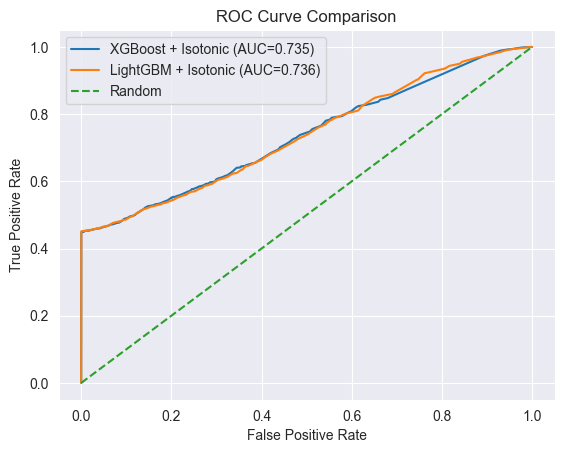

In [23]:
def plot_roc_comparison(y_true, proba_dict):
    plt.figure()
    for name, y_proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.title("ROC Curve Comparison")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(True)
    plt.legend()
    plt.show()

plot_roc_comparison(y_test, {
    xgb_res["model"]: xgb_proba,
    lgbm_res["model"]: lgbm_proba
})

## Feature Importance (Özellik Önemi) Grafikleri

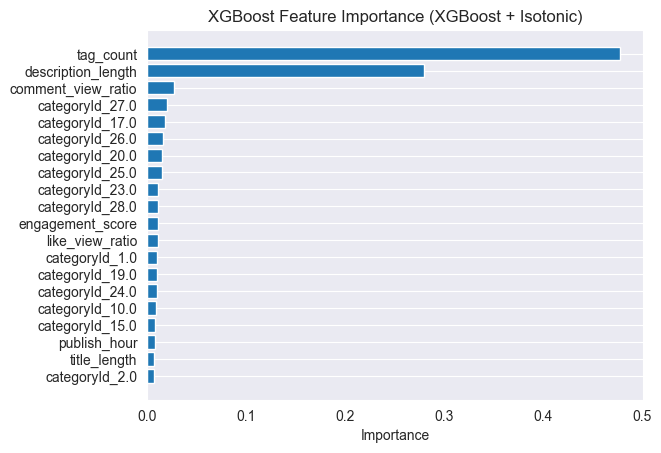

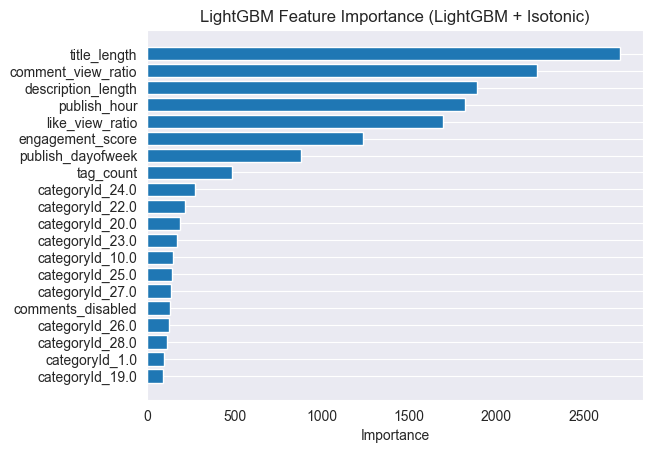

In [24]:
def get_feature_names(preprocessor, categorical_features, numeric_features):
    cat_encoder = preprocessor.named_transformers_["cat"]
    cat_names = list(cat_encoder.get_feature_names_out(categorical_features))
    return cat_names + numeric_features


def plot_feature_importance(trained_model,
                             categorical_features,
                             numeric_features,
                             top_n=20,
                             title="Feature Importance"):

    if hasattr(trained_model, "calibrated_classifiers_"):
        pipeline = trained_model.calibrated_classifiers_[0].estimator
    else:
        pipeline = trained_model

    preprocessor = pipeline.named_steps["preprocess"]
    model = pipeline.named_steps["model"]

    cat_encoder = preprocessor.named_transformers_["cat"]
    cat_names = list(cat_encoder.get_feature_names_out(categorical_features))
    feature_names = cat_names + numeric_features

    importances = model.feature_importances_

    fi_df = (
        pd.DataFrame({"Feature": feature_names, "Importance": importances})
        .sort_values("Importance", ascending=False)
        .head(top_n)
    )

    plt.figure()
    plt.barh(fi_df["Feature"], fi_df["Importance"])
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.xlabel("Importance")
    plt.grid(axis="x")
    plt.show()


plot_feature_importance(
    xgb_clf,
    categorical_features,
    numeric_features,
    top_n=20,
    title=f"XGBoost Feature Importance ({xgb_res['model']})"
)
plot_feature_importance(
    lgbm_clf,
    categorical_features,
    numeric_features,
    top_n=20,
    title=f"LightGBM Feature Importance ({lgbm_res['model']})"
)

## Tahminin Yüdeliğe Çevirilmesi

In [17]:
def predict_trend_potential(model, input_df):
    proba = model.predict_proba(input_df)[:, 1]
    return np.round(proba * 100, 2)

## Test İçin Veri Hazırlama

In [18]:
def prepare_user_input(df: pd.DataFrame, features: list) -> pd.DataFrame:
    df = df.copy()

    # Datetime
    df["publishedAt"] = pd.to_datetime(df["publishedAt"])

    # Time features
    df["publish_hour"] = df["publishedAt"].dt.hour
    df["publish_dayofweek"] = df["publishedAt"].dt.dayofweek
    df["is_weekend"] = df["publish_dayofweek"].isin([5, 6]).astype(int)

    # Engagement features
    df["like_view_ratio"] = df["likes"] / (df["view_count"] + 1)
    df["comment_view_ratio"] = df["comment_count"] / (df["view_count"] + 1)
    df["engagement_score"] = (df["likes"] + df["comment_count"]) / (df["view_count"] + 1)

    # Text features
    df["title_length"] = df["title"].astype(str).str.len()
    df["description_length"] = df["description"].astype(str).str.len()
    df["tags"] = df["tags"].fillna("")
    df["tag_count"] = df["tags"].apply(lambda x: 0 if x == "" else len(str(x).split("|")))



    return df[features]


## 2 Örnek İle Modelin Test Edilmesi

In [20]:
user_input = pd.DataFrame([{
    "view_count": 10,
    "likes": 1,
    "comment_count": 0,
    "categoryId": 22,
    "comments_disabled": 1,
    "publishedAt": "2025-01-05",
    "title": "Hello welcome to my new video we are celebrating my birthday today #birthday #new #video",
    "description": "My birthday please follow my instagram: https://instagram/hello.23476",
    "tags": "New|Video"
}])

user_input2 = pd.DataFrame([{
    "view_count": 125000,
    "likes": 8300,
    "comment_count": 410,
    "categoryId": 20,
    "comments_disabled": 0,
    "publishedAt": "2025-12-05 20:00:00",
    "title": "Best Fortnite gameplay! 50 KILL in new season #birthday #new #video",
    "description": "Amazing gameplay - Fortnite",
    "tags": "Gaming|Fortnite|New|Season12"
}])

final_input1 = prepare_user_input(user_input, FEATURES)
final_input2 = prepare_user_input(user_input2, FEATURES)

trend_score1_xgb = predict_trend_potential(xgb_clf, final_input1)
trend_score2_xgb = predict_trend_potential(xgb_clf, final_input2)

trend_score1_lgbm = predict_trend_potential(lgbm_clf, final_input1)
trend_score2_lgbm = predict_trend_potential(lgbm_clf, final_input2)

print(f"First Video XGB Trend Potential: %{trend_score1_xgb[0]:.2f}")
print(f"First Video LGBM Trend Potential: %{trend_score1_lgbm[0]:.2f}")

print(f"Second Video XGB Trend Potential: %{trend_score2_xgb[0]:.2f}")
print(f"Second Video LGBM Trend Potential: %{trend_score2_lgbm[0]:.2f}")


First Video XGB Trend Potential: %7.02
First Video LGBM Trend Potential: %11.06
Second Video XGB Trend Potential: %99.91
Second Video LGBM Trend Potential: %99.76


## Not:
Ayrıca Modelin testi için *`GUI.py`* arayüzü kullanılabilir.

&nbsp;

#### **GUI çalıştırma adımları:**
```bash
cd Jupyter_Final/22040301135_Muhammed_Chreiki
```
```bash
`streamlit run GUI.py`
```
Bu aşamadan sonra, oluşturulan grafiksel kullanıcı arayüzü aracılığıyla yerel bir sunucu (localhost) üzerinde modeller test edilebilir.